In [1]:
import os
from glob import glob
import json
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings
import music21
warnings.filterwarnings("ignore")

import pretty_midi as pm
from ezchord import Chord

from melody import Melody
from utils import get_chord_progressions

In [2]:
%matplotlib inline

In [3]:
chord_progressions = get_chord_progressions()

In [4]:
version = '1.2'
folder = f"../data/Complete Examples Melodies Auto/v{version}/Real Book"

files = [y for x in os.walk(folder) for y in glob(os.path.join(x[0], '*.mid'))]
files

["../data/Complete Examples Melodies Auto/v1.2/Real Book/'Round Midnight.mid",
 '../data/Complete Examples Melodies Auto/v1.2/Real Book/A Felicidade.mid',
 '../data/Complete Examples Melodies Auto/v1.2/Real Book/A Foggy Day.mid',
 '../data/Complete Examples Melodies Auto/v1.2/Real Book/A Night In Tunisia.mid',
 '../data/Complete Examples Melodies Auto/v1.2/Real Book/Accentuate The Positive.mid',
 '../data/Complete Examples Melodies Auto/v1.2/Real Book/Afro Blue.mid',
 "../data/Complete Examples Melodies Auto/v1.2/Real Book/After You've Gone.mid",
 '../data/Complete Examples Melodies Auto/v1.2/Real Book/Afternoon In Paris.mid',
 "../data/Complete Examples Melodies Auto/v1.2/Real Book/Ain't Misbehavin'.mid",
 '../data/Complete Examples Melodies Auto/v1.2/Real Book/Airegin.mid',
 '../data/Complete Examples Melodies Auto/v1.2/Real Book/Alice In Wonderland.mid',
 '../data/Complete Examples Melodies Auto/v1.2/Real Book/All Blues.mid',
 '../data/Complete Examples Melodies Auto/v1.2/Real Book/

In [5]:
def split_melody(self, quantized):
    bpm = self.time_signature[0]
    ftpm = self.final_ticks_per_beat * bpm
    starting_measure = self.starting_measure

    linear_chord_progression = []

    for section in self.song_structure['sections']:
        linear_chord_progression += self.song_structure['progression'][section]

    n_chord_prog_measures = int(len(linear_chord_progression) / bpm)

    n_measures = self.note_info['measure'].max() + 1

    repetition = 1
    lower_bound = starting_measure
    upper_bound = starting_measure + n_chord_prog_measures

    while upper_bound <= n_measures:
        valid_notes = self.note_info[
            (self.note_info['measure'] >= lower_bound) &
            (self.note_info['measure'] < upper_bound)
        ]

        if len(valid_notes) >= 20:
            notes_df = pd.DataFrame(valid_notes)

            notes_df['measure'] = (
                    notes_df['measure'] -
                    starting_measure -
                    (n_chord_prog_measures * (repetition - 1))
            )
            current_chords = notes_df['measure'].apply(lambda x: linear_chord_progression[int(x * bpm)])
            chord_info = current_chords.apply(self.split_chord)

            notes_df['chord_name'] = current_chords
            notes_df['chord_root'] = chord_info.apply(lambda x: x[0])
            notes_df['chord_bass'] = chord_info.apply(lambda x: x[1])
            notes_df['chord_notes'] = chord_info.apply(lambda x: x[2])

            notes_df['raw_ticks'] -= notes_df['raw_ticks'].min() - notes_df['raw_ticks'].min()
            notes_df['quant_ticks'] -= (notes_df['quant_ticks'].min() - notes_df['quant_ticks'].min() % ftpm)

            split_melody_data_folder = f'{self.split_melody_data_folder}/{self.source}'

            if not os.path.exists(split_melody_data_folder):
                os.makedirs(split_melody_data_folder)

            notes_df.to_csv(f'{split_melody_data_folder}/'
                            f'{self.filename.replace(".mid", "")} '
                            f'{"original" if self.original else "-" + repetition + "-"}.csv')

            split_melody_folder = f'{self.split_melody_folder}/{self.source}'

            if not os.path.exists(split_melody_folder):
                os.makedirs(split_melody_folder)

            split_melody_filepath = os.path.join(
                split_melody_folder,
                f'{self.filename.replace(".mid", "")}{"" if self.original else f" -{repetition}-"}.mid'
            )

            notes_and_chord_to_midi(notes_df, self.song_structure, quantized, split_melody_filepath)

        repetition += 1
        lower_bound += n_chord_prog_measures
        upper_bound += n_chord_prog_measures

        if self.original:
            return True

    return True

In [6]:
def calculate_alignment_score(melody):
    song_scores = []
    step = 1 / self.time_signature[0]
    ftpm = self.final_ticks_per_beat * self.time_signature[0]
    position = offset * step

    for section in self.song_structure['sections']:
        for chord in self.song_structure['progression'][section]:
            pitches = self.note_info[
                (melody['measure'] + (melodyo['offset'] / ftpm) >= position) &
                (melody['measure'] + (melody['offset'] / ftpm) < position + step)
            ]['pitch'].values

            scores = [self.chord_note_score(chord, pitch) for pitch in pitches]

            score = np.mean(scores) if len(scores) > 0 else 0.5
            song_scores.append(score)

            position += step

    return song_scores

In [7]:
def chord_progression_comparison(self):
    bpm = self.time_signature[0]

    n_chord_prog_measures = int(np.sum([
        len(self.song_structure['progression'][section])
        for section in self.song_structure['sections']]
    ) / bpm)

    n_measures = int(self.note_info['measure'].max() + 1)

    min_measure = self.note_info.measure.min()
    max_measure = int(np.ceil((self.note_info.measure + ((self.note_info.offset + self.note_info.quant_duration) / self.final_ticks_per_beat / self.time_signature[0])).max())) - 1
    
    outro_init = (max_measure - min_measure + 1) % n_chord_prog_measures
#     outro_auto = (max_measure - self.starting_measure + 1) % n_chord_prog_measures
    
    return {
        'filename': self.filename,
        'cp_measures': n_chord_prog_measures,
        'n_measures': n_measures,
        'repetitions': n_measures // n_chord_prog_measures,
#         'start_measure': self.starting_measure,
        'min_measure': min_measure,
        'max_measure': max_measure,
        'outro_init': outro_init,
#         'outro_auto': outro_auto,
#         'outro_difference': outro_init - outro_auto
    }

In [8]:
def notes_and_chord_to_midi(
        notes: pd.DataFrame,
        chord_progression: dict,
        quantized: bool,
        out_file: str) -> pm.PrettyMIDI:
    instrument_name = "Acoustic Grand Piano"
    
    print(notes)

    p = pm.PrettyMIDI()
    melody = pm.Instrument(
        program=pm.instrument_name_to_program(instrument_name),
        name="melody"
    )
    chords = pm.Instrument(
        program=pm.instrument_name_to_program(instrument_name),
        name="chords"
    )

    if quantized:
        ticks_col = "quant_ticks"
        durations_col = "quant_duration"
        
        multiplier = 1/48
    else:
        ticks_col = "raw_ticks"
        durations_col = "raw_duration"
        
        multiplier = 1

    for i, note in notes.iterrows():
        
        start = note[ticks_col] * multiplier
        end = (note[ticks_col] + note[durations_col]) * multiplier

        note = pm.Note(
            velocity=127,
            pitch=int(note["pitch"]),
            start=note[ticks_col] * multiplier,
            end=end,
        )
        melody.notes.append(note)

    p.instruments.append(melody)

    start = 0
    use_tonic = True

    for section in chord_progression['sections']:
        for chord in chord_progression['progression'][section]:
            chord_notes = Chord(chord).getMIDI()

            if use_tonic:
                note = pm.Note(
                    velocity=64,
                    pitch=int(chord_notes[0]),
                    start=start,
                    end=start + 0.5,
                )
                chords.notes.append(note)
            else:
                for chord_note in chord_notes[1:]:
                    note = pm.Note(
                        velocity=64,
                        pitch=int(chord_note),
                        start=start,
                        end=start + 0.5,
                    )
                    chords.notes.append(note)

            start += 0.5
            use_tonic = not use_tonic

    p.instruments.append(chords)

    p.write(out_file)

    return p

In [9]:
def manually_align(file, starting_measure):
    melody = Melody(file, version)
    melody.setup()

    error = None

    results = {}
    
    print(os.path.basename(file))
    print('--------------------------------')

    if melody.song_name not in chord_progressions:
        error = 'no chords'

    if melody.time_signature is None:
        error = 'no time'

    if melody.time_signature[0] != 4:
        error = 'no 4/4'

    if error is None:      
        melody.set_song_structure(chord_progressions[melody.song_name])        
        melody.align_key()
        melody.parse_notes()
        
        print(melody.note_info.head(20))
        print(melody.song_structure)
        
        results = chord_progression_comparison(melody)

        align_score = round(np.mean(melody.calculate_alignment_score(results['outro_init'])) * 100)

        print('{0: <15}'.format('align_scores'), align_score)

#         for k, v in results.items():
#             print('{0: <15}'.format(k), v)

        melody.starting_measure = starting_measure

        split_melody(melody, quantized=True)

#         print('..................')
#         print(melody.note_info.head(5)[['offset', 'measure']]) 
    else:
        print(os.path.basename(file))
#         print('--------------------------------')
        print(f'ERROR: {error}')
        
#     print('################################')
    
    del melody
    
    return results

In [10]:
manually_align('../data/Complete Examples Melodies Auto/v1.2/Jazz Standards/Beauty And The Beast.mid', 0)

Beauty And The Beast.mid
--------------------------------
0 288 48
6 294 48
12 300 48
14 302 48
24 312 48
26 314 48
27 315 48
36 324 48
39 327 48
6 390 48
8 392 48
12 396 48
14 398 48
24 408 48
26 410 48
27 411 48
36 420 48
39 423 48
6 486 48
8 488 48
12 492 48
14 494 48
24 504 48
26 506 48
27 507 48
36 516 48
39 519 48
38 566 48
0 576 48
30 606 48
36 612 48
6 630 48
12 636 48
0 864 48
6 870 48
12 876 48
14 878 48
24 888 48
26 890 48
27 891 48
36 900 48
39 903 48
6 966 48
8 968 48
12 972 48
14 974 48
24 984 48
26 986 48
28 988 48
36 996 48
39 999 48
6 1062 48
8 1064 48
12 1068 48
14 1070 48
24 1080 48
26 1082 48
26 1082 48
37 1093 48
39 1095 48
38 1142 48
0 1152 48
31 1183 48
36 1188 48
6 1206 48
8 1208 48
0 1248 48
3 1251 48
12 1260 48
14 1262 48
24 1272 48
26 1274 48
36 1284 48
38 1286 48
12 1308 48
36 1332 48
39 1335 48
12 1356 48
36 1380 48
39 1383 48
39 1431 48
44 1436 48
0 1440 48
2 1442 48
6 1446 48
8 1448 48
12 1452 48
15 1455 48
18 1458 48
21 1461 48
24 1464 48
27 1467 48
30 1

TypeError: can only concatenate str (not "int") to str

In [ ]:
all_results = []

for file in files:
    print(file)
    results = manually_align(file)
    
    all_results.append(results)

In [12]:
res = pd.DataFrame().from_dict(all_results)

In [13]:
res.tail()

,filename,cp_measures,n_measures,repetitions,min_measure,max_measure,outro_init
207,Pick Yourself Up.mid,32.0,97.0,3.0,2.0,97.0,0.0
208,Polka Dots And Moonbeams.mid,32.0,100.0,3.0,2.0,99.0,2.0
209,Prelude To A Kiss.mid,32.0,100.0,3.0,2.0,99.0,2.0
210,Recado Bossa Nova.mid,72.0,170.0,2.0,1.0,169.0,25.0
211,Reflections.mid,32.0,99.0,3.0,2.0,99.0,2.0


In [24]:
res[res['min_measure'] == 5]

,filename,cp_measures,n_measures,repetitions,min_measure,max_measure,outro_init
154,Beauty And The Beast.mid,36.0,123.0,3.0,5.0,122.0,10.0


In [15]:
res['outro_init'].value_counts()

2.0     73
3.0     59
0.0     18
1.0      6
30.0     4
5.0      3
10.0     3
4.0      3
12.0     2
27.0     2
8.0      2
25.0     2
42.0     1
18.0     1
39.0     1
6.0      1
7.0      1
38.0     1
47.0     1
14.0     1
56.0     1
24.0     1
36.0     1
98.0     1
17.0     1
22.0     1
50.0     1
33.0     1
Name: outro_init, dtype: int64

<AxesSubplot:xlabel='outro_init', ylabel='Count'>

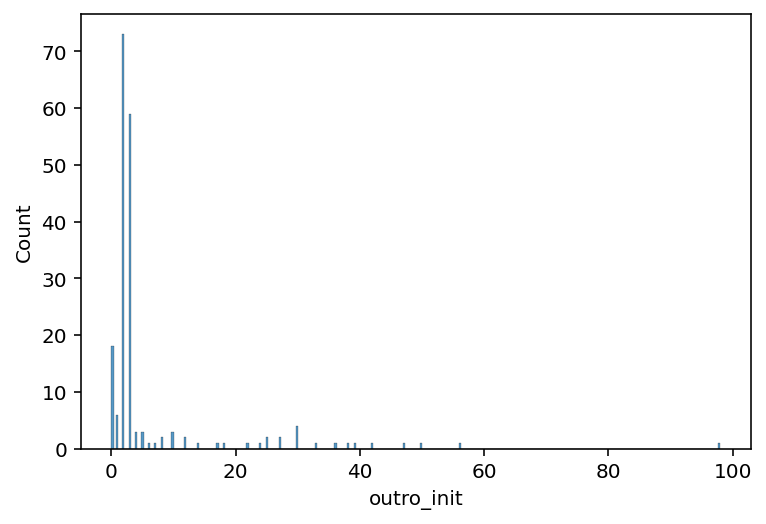

In [16]:
sns.histplot(res['outro_init'])

In [ ]:
r = pd.read_csv('../data/split_melody_data/v1.2/Real Book/')

In [ ]:
res.set_index('filename').loc['All Of Me.mid']

In [ ]:
alignment = json.load(open('../data/alignment_scores/alignment-09-02-2022-21-20-09.json'))

In [ ]:
errors = json.load(open('../data/alignment_scores/errors-09-02-2022-21-20-09.json'))

In [ ]:
bad = [(k,v) for k, v in alignment.items() if v['remainder'] > 6 or v['starting_measure'] > 10]

In [ ]:
[v[0] for v in bad]

In [ ]:
df = pd.read_json(open('../data/alignment_scores/alignment-09-02-2022-21-20-09.json')).T

In [ ]:
df[(df['remainder'] > 3) & (df['starting_measure'] > 3)]

In [ ]:
sns.distplot([v['remainder'] for j,v in alignment.items()])

In [ ]:
sns.distplot([v['reps'] for j,v in alignment.items()])

In [ ]:
sns.distplot([v['starting_measure'] for j,v in alignment.items()])